# COMPUTATIONAL EFFICIENCY RESULTS

In [6]:

from data import UKDALEData
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from modelGen import modelGen
from address import get_model_path
%matplotlib inline



In [7]:
dataGen = UKDALEData(path="./data/")
trainMain,trainTargets, trainStates = dataGen.get_train_sequences(houses = 1,
                                                                  start = "2015-01-01",
                                                                  end="2016-01-01")
testMain,testTargets, testStates = dataGen.get_test_sequences(houses = 1,
                                                              start = "2016-01-01",
                                                              end="2016-02-01",
                                                              norm=False)


data= {"X_train":trainMain,
        "Y_train":trainTargets,
        "Y_states":trainStates,
        "Z_train":trainStates,
        "X_test":testMain,
        "Y_test":testTargets,
        "Z_test":testStates,
        "app_data":dataGen.get_app_data(),
        "main_data": dataGen.get_main_mean_std()
        } 

Loading the models

In [9]:

MODELSID = ["biLSTM","FCNdAE","multiFCNdAE","multiUNET"]
SEQ_LEN = [100,500,1440]
APP_LABELS = list(data["app_data"].keys())
MODELS = []
WEIGHTS = []
TIMES   = []
n = 10 # Number of inferences to compute the averaged inference time
%%capture

for seq in SEQ_LEN:
    w = []
    t = []
    for modelID in MODELSID:
        MODELS.append(modelGen(modelID=modelID,data=data, params = {"sequence_length":seq}))
        # weights
        w.append(MODELS[-1].get_num_weights())
        # inference times
        X_random = np.random.rand(10*60*5) #1 day of data
        t.append(MODELS[-1].get_inference_time(X_random,n))


    WEIGHTS.append(w)
    TIMES.append(t)

#for ii,modelID in enumerate(MODELSID):
#    print(f"nº trainable weights {modelID}: {WEIGHTS[ii]}")



In [26]:
WEIGHTS = np.array(WEIGHTS)
TIMES   = np.array(TIMES)
MODELSLABELS = ["biLSTM","FCNdAE","multiFCNdAE","UNET"]
df_weights = pd.DataFrame(WEIGHTS.T,columns=SEQ_LEN,index =MODELSLABELS)/1e6
df_weights = df_weights.loc[["multiFCNdAE","FCNdAE","UNET","biLSTM"]]

df_times   = pd.DataFrame(TIMES.T,columns=SEQ_LEN,index =MODELSLABELS)
df_times   = df_times.loc[["FCNdAE","UNET","multiFCNdAE","biLSTM"]]
df_times   = df_times # miliseconds

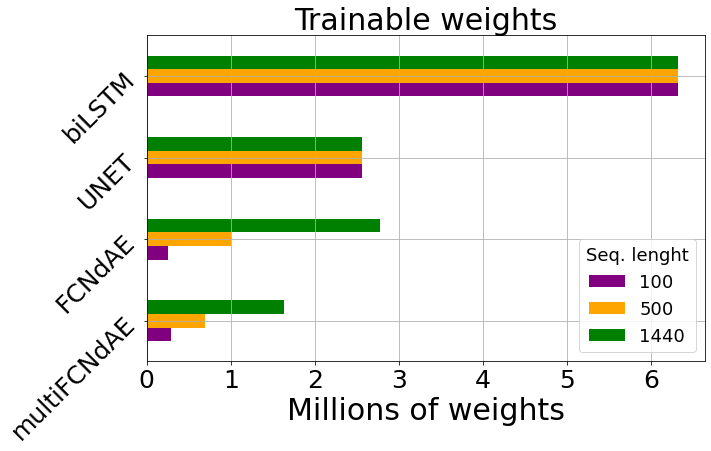

In [14]:
# Fig weights
colors = ['purple', 'orange','green']
ax = df_weights.plot.barh(grid=True,
                       color=colors,
                       figsize=(10,6))
plt.title("Trainable weights",fontdict={'fontsize':30})
plt.xlabel("Millions of weights",fontdict={'fontsize':30})
ax.tick_params("x",labelsize=25)
ax.tick_params("y",labelrotation=45,labelsize=25)
ax.legend(title="Seq. lenght",fontsize=18,title_fontsize=18)

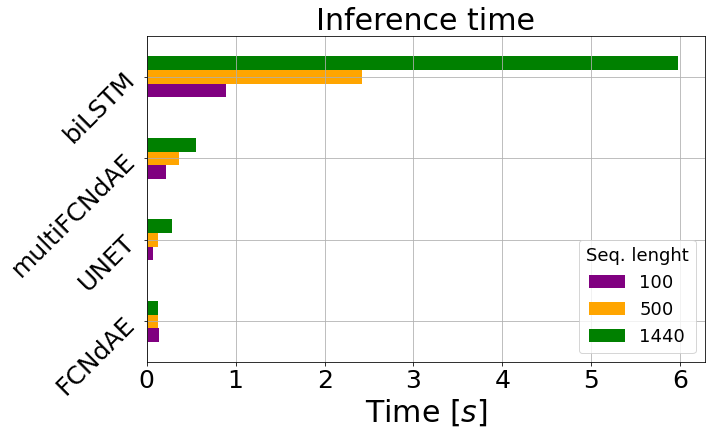

In [27]:
# Fig times
#df_times *=1000
colors = ['purple', 'orange','green']
ax = df_times.plot.barh(grid=True,
                       color=colors,
                       figsize=(10,6))
plt.title("Inference time",fontdict={'fontsize':30})
plt.xlabel(r"Time [$s$]",fontdict={'fontsize':30})
ax.tick_params("x",labelsize=25)
ax.tick_params("y",labelrotation=45,labelsize=25)
ax.legend(title="Seq. lenght",fontsize=18,title_fontsize=18)